In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def plot_point_clouds(gt_pts, pred_pts, title, draw_lines=True, loss_type="L2"):
    """
    Visualizes Ground Truth (Blue) vs Predicted (Red) points.
    Draws lines to show which points are being compared by the loss function.
    """
    plt.figure(figsize=(8, 8))
    
    # Convert to numpy
    gt = gt_pts.numpy()
    pred = pred_pts.numpy()
    
    plt.scatter(gt[:, 0], gt[:, 1], c='blue', label='Ground Truth', s=50, alpha=0.6)
    plt.scatter(pred[:, 0], pred[:, 1], c='red', label='Prediction', s=50, alpha=0.6)
    
    # Draw correspondence lines
    if draw_lines:
        if loss_type == "L2":
            # L2 compares index i to index i
            for i in range(len(gt)):
                plt.plot([gt[i, 0], pred[i, 0]], [gt[i, 1], pred[i, 1]], 'k-', alpha=0.2)
        elif loss_type == "Chamfer":
            # Chamfer compares to NEAREST neighbor
            # Compute distance matrix
            dists = torch.cdist(gt_pts.unsqueeze(0), pred_pts.unsqueeze(0)).squeeze(0)
            # For each GT point, find nearest Pred
            min_indices = torch.argmin(dists, dim=1)
            for i in range(len(gt)):
                nearest_idx = min_indices[i]
                plt.plot([gt[i, 0], pred[nearest_idx, 0]], [gt[i, 1], pred[nearest_idx, 1]], 'g-', alpha=0.2)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

## 1. The "Aligned" Case (Asymmetric Objects)

For asymmetric objects (like a shoe or a mug), there is only one correct pose.
Our network predicts a rotation $R_{pred}$ and translation $t_{pred}$.
We transform the canonical points $P$ to get predicted points: $P_{pred} = R_{pred} P + t_{pred}$.
We compare this to ground truth: $P_{gt} = R_{gt} P + t_{gt}$.

Since both sets of points originate from the same canonical $P$, $P_{pred}[i]$ corresponds physically to $P_{gt}[i]$.

L2 Loss (ADD): 0.1652


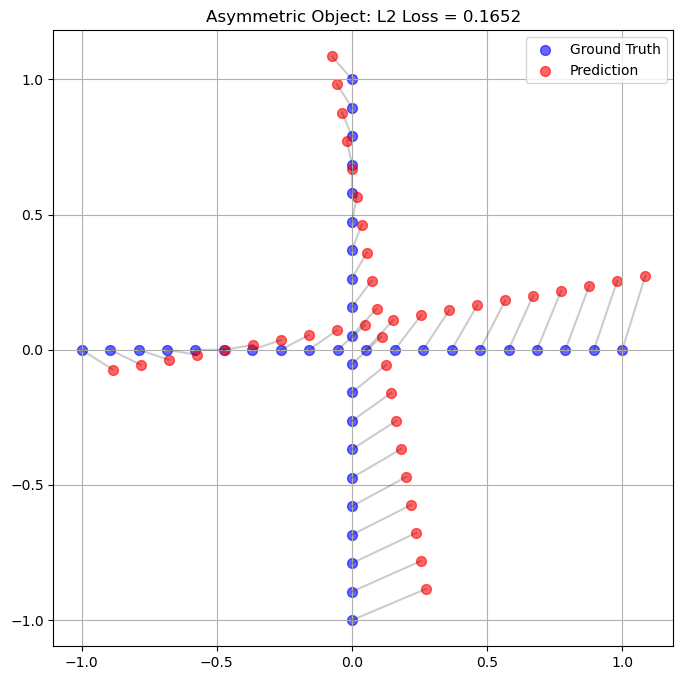

In [6]:
# Generate an asymmetric shape (e.g., an 'L' shape)
num_points = 20
x = torch.linspace(-1, 1, num_points)
y = torch.zeros(num_points)
pts1 = torch.stack([x, y], dim=1)
pts2 = torch.stack([torch.zeros(num_points), x], dim=1)
# Combine to make an L shape
canonical_points = torch.cat([pts1, pts2], dim=0)

# Ground Truth Pose (Identity)
gt_points = canonical_points

# Predicted Pose (Slight Rotation + Noise)
theta = np.radians(10) # 10 degree error
R_pred = torch.tensor([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], dtype=torch.float32)
pred_points = canonical_points @ R_pred.T + 0.1 # Add translation

# Calculate L2 Loss (ADD)
# We compare point i to point i
l2_loss = torch.norm(pred_points - gt_points, dim=1).mean()

print(f"L2 Loss (ADD): {l2_loss.item():.4f}")

plot_point_clouds(gt_points, pred_points, f"Asymmetric Object: L2 Loss = {l2_loss:.4f}", loss_type="L2")

**Observation**: The black lines connect corresponding points (index-to-index). Since the rotation error is small, the lines are short. The loss accurately reflects the pose error.

## 2. The Symmetry Problem

Now consider a symmetric object, like a circular plate.
Rotating the plate by 180 degrees results in the **same geometric shape**.
However, if we simply rotate the points, point $i$ moves to the opposite side.

If the network predicts a 180-degree rotation (which is a valid pose for a symmetric object), the standard L2 loss will be huge because it compares point $i$ (now on the left) to point $i$ (originally on the right).

L2 Loss (ADD) for Symmetric Pose: 2.0000
The loss is high, even though the shape overlaps perfectly!


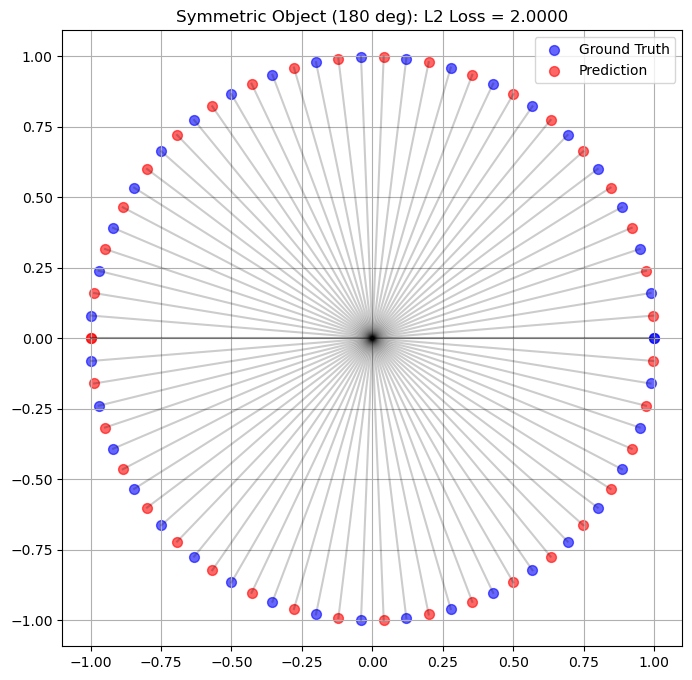

In [7]:
# Generate a symmetric shape (Circle)
angles = torch.linspace(0, 2*np.pi, 40)
x = torch.cos(angles)
y = torch.sin(angles)
circle_points = torch.stack([x, y], dim=1)

gt_points_sym = circle_points

# Predicted Pose: 180 degree rotation (Symmetric equivalent)
# Geometrically, this is the SAME object pose.
theta_sym = np.radians(180) 
R_sym = torch.tensor([[np.cos(theta_sym), -np.sin(theta_sym)], [np.sin(theta_sym), np.cos(theta_sym)]], dtype=torch.float32)
pred_points_sym = circle_points @ R_sym.T

# Calculate L2 Loss (ADD)
# This will be HIGH because point 0 is compared to point 0's rotated position (opposite side)
l2_loss_sym = torch.norm(pred_points_sym - gt_points_sym, dim=1).mean()

print(f"L2 Loss (ADD) for Symmetric Pose: {l2_loss_sym.item():.4f}")
print("The loss is high, even though the shape overlaps perfectly!")

plot_point_clouds(gt_points_sym, pred_points_sym, f"Symmetric Object (180 deg): L2 Loss = {l2_loss_sym:.4f}", loss_type="L2")

**Observation**: The black lines cross the entire circle! The loss is calculating the diameter of the circle, penalizing a perfectly valid symmetric pose. This confuses the network.

## 3. The Solution: Chamfer Distance (ADD-S)

For symmetric objects, we don't care *which* point matches *which*. We just want to know: **"Is the predicted shape close to the ground truth shape?"**

Chamfer distance calculates, for each predicted point, the distance to the **nearest** ground truth point, regardless of index.

Chamfer Loss (ADD-S): 0.1611
The loss is near zero, correctly recognizing the valid pose.


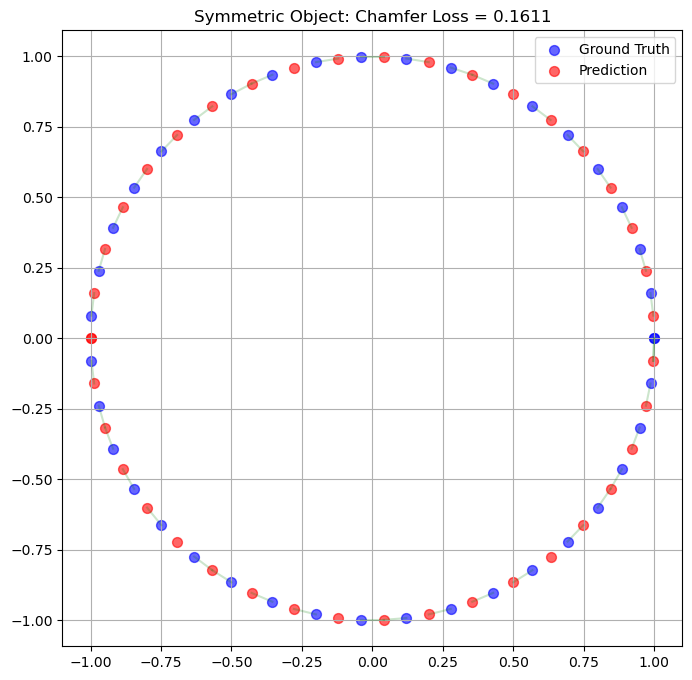

In [8]:
def chamfer_distance_demo(p1, p2):
    # p1, p2: (N, 2)
    dists = torch.cdist(p1.unsqueeze(0), p2.unsqueeze(0)).squeeze(0) # (N, N) matrix
    
    # Distance from p1 to nearest in p2
    min_dist1, _ = torch.min(dists, dim=1)
    
    # Distance from p2 to nearest in p1
    min_dist2, _ = torch.min(dists, dim=0)
    
    return torch.mean(min_dist1) + torch.mean(min_dist2)

# Calculate Chamfer Loss
chamfer_loss = chamfer_distance_demo(pred_points_sym, gt_points_sym)

print(f"Chamfer Loss (ADD-S): {chamfer_loss.item():.4f}")
print("The loss is near zero, correctly recognizing the valid pose.")

plot_point_clouds(gt_points_sym, pred_points_sym, f"Symmetric Object: Chamfer Loss = {chamfer_loss:.4f}", loss_type="Chamfer")

**Observation**: The green lines connect each point to its nearest neighbor. Since the shapes overlap perfectly, the lines are tiny (length ~0), and the loss is effectively zero. This allows the network to learn symmetric poses correctly.